In [137]:
import xarray
import numpy
import matplotlib.pyplot as mp
import cartopy

import glob

In [108]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/'

# approx lat lon ranges from WRF

In [146]:
lat_lo = -37.
lat_hi = 37.
lon_lo = -155
lon_hi = -25

lon_lo_360 = lon_lo+360.
lon_hi_360 = lon_hi+360.

# import control run (mar 16 10 days)

In [158]:
data_dir = root_dir + 'B_1850_CAM5.cam0400.clm0400_mar16/atm/hist/'
cont_ds = xarray.open_mfdataset(data_dir + '*.nc')
cont_ds_amazon = control_ds.sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo_360,lon_hi_360))

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


# import phys run (mar 16 10 days)

In [159]:
data_dir = root_dir + 'B_1850_CAM5.cam0400.clm1000_mar16/atm/hist/'
phys_ds = xarray.open_mfdataset(data_dir + '*.nc')
phys_ds_amazon = phys_ds.sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo_360,lon_hi_360))

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [213]:
landfrac_amazon = cont_ds_amazon['LANDFRAC'][0,:,:].values

# extract precip, tmq and difference them

In [160]:
cont_prect = cont_ds_amazon['PRECC']+cont_ds_amazon['PRECL']
phys_prect = phys_ds_amazon['PRECC']+phys_ds_amazon['PRECL']

In [161]:
lon_data = cont_ds_amazon['lon'].values
lat_data = cont_ds_amazon['lat'].values

In [188]:
diff_prect = phys_prect.values-cont_prect.values
diff_tmq = phys_ds_amazon['TMQ'].values-cont_ds_amazon['TMQ'].values

In [189]:
diff_prect_time_mean = diff_prect.mean(axis=0)
diff_tmq_time_mean = diff_tmq.mean(axis=0)

In [197]:
diff_prect_time_mean_day1 = numpy.mean(diff_prect[:24,:,:], axis=0)
diff_tmq_time_mean_day1 = numpy.mean(diff_tmq[:24,:,:], axis=0)

# extract pressure, u and omega winds, 3d moisture

pressure is defined as:

p $ _{(i,j,k) }$= A$ _{k}$P$ _{0}$+ B$ _{k}$P$ _{s}$(i,j)

where p is the pressure at a given level and latitude, longitude grid point. The coefficients A, B and P$ _{0}$are constants. P$ _{s}$ is the model's current surface pressure. P$ _{0}$ is set in the model code. The input model initial conditions dataset sets A and B through the variables hyam, hyai, hybm, and hybi. The subscript "i" refers to interface levels, and "m" refers to the mid-point levels. "hyam" then refers to Hybrid level "A" coefficient on the interfaces.

for my application:

p = hyam * P0 + 

In [217]:
print(cont_ds_amazon['P0'].shape)
print(cont_ds_amazon['hyam'].shape)
print(cont_ds_amazon['hybm'].shape)
print(cont_ds_amazon['PS'].shape)

(265,)
(265, 30)
(265, 30)
(265, 78, 105)


In [223]:
cont_p = numpy.zeros((cont_ds_amazon['Q'].shape))

In [224]:
cont_p.shape

(265, 30, 78, 105)

In [260]:
cont_hyam = cont_ds_amazon['hyam'].values
cont_hybm = cont_ds_amazon['hybm'].values
cont_p0 = cont_ds_amazon['P0'].values
cont_ps = cont_ds_amazon['PS'].values

In [262]:
nt, nlev, nlat, nlon = cont_p.shape
for t in range(nt):
    for lev in range(nlev):
        for i in range(nlat):
            for j in range(nlon):
                cont_p[t,lev,i,j] = cont_hyam[t,lev]*cont_p0[0] + \
                                    cont_hybm[t,lev]*cont_ps[t,i,j]

In [263]:
cont_p.shape

(265, 30, 78, 105)

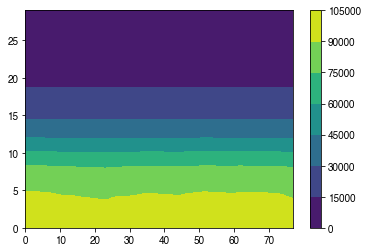

In [266]:
cf=mp.contourf(cont_p[0,::-1,:,:].mean(axis=2));mp.colorbar(cf)

In [255]:
cont_ds_amazon['hyam'][t,lev].values*cont_ds_amazon['P0'].values[0]

6650.169566273689

In [256]:
cont_ds_amazon['hybm'][t,lev].values*cont_ds_amazon['PS'][t,i,j].values

64112.92991654738

In [250]:
cont_ds_amazon['hybm'].values

array([[0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ],
       [0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ],
       [0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ],
       [0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ],
       [0.        , 0.        , 0.        , ..., 0.95123053, 0.974336  ,
        0.9925561 ]])

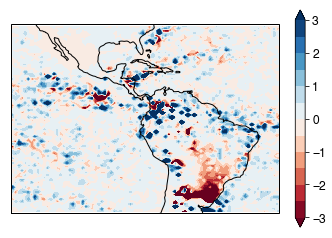

In [210]:
fontsize=12
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})

ax.coastlines()
ax.set_extent([lon_lo+23.,lon_hi-2.,lat_lo,lat_hi], crs=cartopy.crs.PlateCarree())

contour_plot = ax.contourf(lon_data,lat_data,diff_prect[12,:,:]*1000.*86400., \
            levels=numpy.arange(-3,3.1,0.5), \
            cmap='RdBu', \
            extend='both')

cbar = mp.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=fontsize)

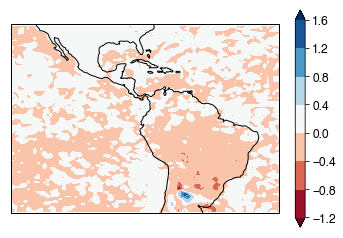

In [199]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})

ax.coastlines()
ax.set_extent([lon_lo+23.,lon_hi-2.,lat_lo,lat_hi], crs=cartopy.crs.PlateCarree())

contour_plot = ax.contourf(lon_data,lat_data,diff_tmq_time_mean_day1, \
            #levels=numpy.arange(-1,1.1,0.2), \
            cmap='RdBu', \
            extend='both')

cbar = mp.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=fontsize)
